# Mnist 손글씨 분류

- MNIST 데이터베이스는 손으로 쓴 숫자들로 이루어진 대형 데이터베이스이다. 

- 본 데이터셋은 다양한 화상 처리 시스템, 기계학습 분야를 트레이닝하기 위해 일반적으로 사용된다.

- MNIST 데이터셋 은 위 그림과 같이 0에서 9까지 10가지로 분류될 수 있는 손글씨 숫자 이미지 70,000개로 이루어져 있다.

- 각 이미지는 28×28 픽셀로 구성되고 각 픽셀은 아래와 같이 0~255 사이의 숫자 행렬로 표현된다.

- 이러한 60,000개의 이미지는 인공 신경망의 훈련 (Training)에 사용되고, 10,000개의 이미지는 테스트 (Test)에 사용된다.

### 1. Setting

- 파이썬 3.7 이상을 요구한다.

- 사이킷런 1.0.1 이상을 요구한다.

In [1]:
import sys
assert sys.version_info >= (3, 7)

In [2]:
import sklearn
assert sklearn.__version__ >= "1.0.1"

- 다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=28, titlesize=28)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

- Graph 폰트 깨짐을 방지한다.

In [37]:
# 폰트 설정 = graph 폰트 깨짐 방지

import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt
!apt -qq install fonts-nanum
fe = fm.FontEntry(
    fname = r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name = 'NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})

'apt'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### 2. Dataset Load

- 적재된 객체는 사전 자료형에 기타 속성(data,target 등)이 추가된 Bunch 자료형이다.

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
type(mnist)

sklearn.utils._bunch.Bunch

- `Bunch` 자료형은 다양한 속성을 갖고 있다. 

- 여기서는 입력데이터셋(`data`)과 타깃 데이터셋(`target`) 속성만 활용한다.  나머지 속성은 데이터셋 관련 기타 정보를 저장한다.

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist.data, mnist.target

### 3. EDA

In [9]:
print(X.shape)
print("-" * 50)
print(X)

(70000, 784)
--------------------------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
print(y.shape)
print("-" * 50)
print(y[0])

(70000,)
--------------------------------------------------
5


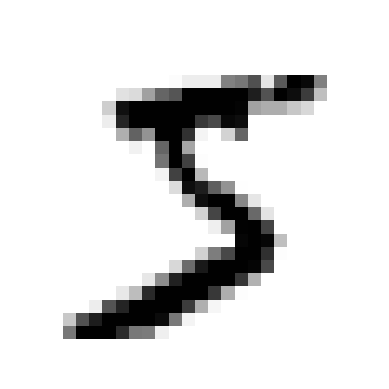

In [16]:
import matplotlib.pyplot as plt

# 28x28 모양의 2차원 어레리로 변환 후 이미지 그리기

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 첫째 이미지 그리기
plot_digit(X[0])
plt.show()

In [17]:
y[0]

'5'

**[EDA 요약]**

- X : 샘플 수는 70,000개의 이미지이며, 이미지는 길이가 784(=28x28)인 1차원 어레이로 되어 있다.

- y : 레이블 또한 70,000개 이며, 0부터 9까지의 숫자이다.

- X[0] 첫째 손글씨 이미지는 5를 표현하는 것으로 보이며 레이블인 y[0] 또한 숫자 5로 일치한다.

### 4. Data 전처리

- 본래 훈련모델 적용을 위해 훈련 데이터셋을 splite 하는 과정을 거쳐야 한다.

- 하지만 본 자료는 이미 6:1 의 비율로 훈련셋과 데이터셋으로 분류되어 있으니 확인 절차만 밟는다.

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

60000 60000
10000 10000


### 5. 이진 분류기 훈련

**[숫자-5 감지기 훈련]**

- 이미지가 숫자 5를 표현하는지 여부만을 판단하는 이진 분류기의 훈련을 위해 레이블을 0 또는 1로 변경한다.

    - 0: 숫자 5 아님.
    - 1: 숫자 5 맞음.

In [19]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

print(y_train_5)
print(len(y_train_5),len(y_test_5))

[ True False False ...  True False False]
60000 10000


- `SGDClassifier` (확률적 경사 하강법)을 적용하여 객체를 훈련 데이터 `X_train`과 이진 분류의 타겟 값인 `y_train_5`에 대해 학습시킨다.

- 이 과정을 거치면 `sgd_clf` 객체는 `X_train` 데이터와 `y_train_5` 타겟 값을 기반으로 학습된 이진 분류 모델을 나타내게 된다.

In [20]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=2024)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=2024)

- 이 5 이진분류기 모델을 테스트해 본 결과, 첫째 샘플의 예측값은 `True`, 즉, 숫자 5라고 맞추는 것을 확인할 수 있다.

In [21]:
sgd_clf.predict([X[0]])

array([ True])

### 6. 분류기 성능 측정

#### 6.1 교차 검증 활용 정확도 측정

- `cross_val_score` 함수로 교차 검증을 통해 모델의 성능을 평가한다.

- `SGDClassifier` 모델에 대해 3-폴드 교차 검증을 수행하고, 각 폴드에서의 정확도(accuracy)를 측정한다.

- 교차 검증을 통해 얻은 각 폴드에서의 정확도 값을 반환한다. 이 값들은 각 폴드에 대한 모델의 성능을 나타낸다.

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9625 , 0.96185, 0.96125])

**[참고]**

- 성능 평가 점수 등이 책의 내용과 조금 다를 수 있지만, 어떤 문제가 있는 것은 아니다. 결과가 조금씩 달라지는 이유는 아래와 같다.

    1. 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 값이 바뀔 수 있다.

    2. 많은 훈련 알고리즘이 확률적, 즉 무작위성에 의존한다.

       이론적으로 `random_state=42`나 `np.random.seed(42)` 등 난수 생성기에 시드를 지정하여 일관된 결과를 얻을 수 있지만 항상 보장되지는 않는다.
      
    3. 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 실행되면
    
       연산이 실행되는 정확한 순서가 항상 보장되지 않으며, 따라서 결괏값이 조금 다를 수 있다.
    
    4. 파이썬 사전(dict)이나 셋(set) 객체는 항목을 사용하는 순서가 경우에 따라 달라질 수 있다.

#### 6.2 오차 행렬, 정밀도, 재현율

#### 6.2.1 오차행렬

- 교차 검증을 이용하여 예측을 수행하고, 이를 이용하여 오차 행렬을 생성한다.

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- `confusion_matrix` 함수는 혼동 행렬(confusion matrix)을 생성하는 데 사용된다.

- 훈련 세트에 대한 실제 타겟 값인 `y_train_5`와 모델의 예측값인 `y_train_pred`를 기반으로 혼동 행렬을 계산한다.

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53863,   716],
       [ 1572,  3849]], dtype=int64)

- 위 혼동행렬은 다음 출력값을 보여준다.

    TN | FP
    ---|---
    FN | TP

    <br/>
    
    - TN: 참 음성 개수. 즉, 5가 아닌 이미지를 5가 아니라고 정확하게 예측한 경우의 수

    - FP: 거짓 양성 개수. 즉, 5가 아닌 이미지를 5라고 잘못 예측한 경우의 수

    - FN: 거짓 음성 개수. 즉, 5를 나타내는 이미지를 5가 아니라고 잘못 예측한 경우의 수
    
    - TP: 참 양성 개수. 즉, 5를 나타내는 이미지를 5라고 정확하게 예측한 경우의 수

#### 6.2.2 정밀도, 재현율, F1 Score

- 정밀도 : 양성으로 예측한 샘플 중에서 실제로 양성인 샘플의 비율

- 정밀도 = TP / TP + FP

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8431544359255203

- 재현율 : 실제 양성인 샘플 중에서 모델이 양성으로 정확하게 예측한 샘플의 비율
    
- 재현율 = TP / TP + FN

In [26]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.710016602102933

- F1 Score : 정밀도(Precision)와 재현율(Recall)의 조화 평균
    
- F! Score = 2 * 정밀도 * 재현율 / 정밀도 + 재현율

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7708792309232926

**[트레이드오프]**

- 재현율이 커지면 정밀도가 작아지고, 정밀도가 커지면 재현율이 작아지는 현상을 정밀도/재현율 트레이드오프라고 한다.

- 정밀도와 재현율은 상호 반비례 관계다. 따라서 정밀도와 재현율 사이의 적절한 비율을 유지하는 분류기를 찾아야 한다. 

- 정밀도와 재현율의 비율은 결정 임곗값에 의해 결정된다.

**[Point]**

- 정밀도가 상대적으로 더 중요한 지표인 경우

  : 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

    ⇒ 스팸 메일

- 재현율이 상대적으로 더 중요한 지표인 경우

  : 실제 Positive 양성인 데이터 예측을 Negative 음성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    
    ⇒ 암 진단, 금융사기 판별

- 분류 결정 임곗값이 낮아질수록 Positive로 예측할 확률이 높아진다.

- 그러면 재현율이 증가하며 기본 임계값이 0.5인데 0.5보다 크면 무조건 Positive로 예측하고 0.5보다 작으면 무조건 Negative로 예측한다.

- 근데 임계값을 0.4로 낮추면 Positive로 예측하는 게 더 많아져 재현율이 증가한다.

- 정밀도와 재현율 중에 더 중요한 지표가 무엇인지 판단하고 임계값을 조정하는 것이 중요하다.

#### 6.2.3 결정 임곗값, 정밀도, 재현율 그래프 그리기

- 결정 함수를 이용해서 교차검증을 실행하면 각 샘플에 대한 결정 함수의 값으로 구성된 어레이 생성

- 분류기마다 결정 함수로 사용되는 메서드 제공

- `SGDClassifier`는 `decision_function()` 메서드를 결정 함수로 이용하며, 각 샘플마다 점수 계산. 기본 임계값은 0.

- 즉 결정 함숫값이 0보다 작으면 음성, 0보다 같거나 크면 양성으로 판정한다.

- 확률적 경사하강법으로 교차검증 수행 (cv = 3)

- `method="decision_function"`은 분류기의 결정 함수(decision function)를 이용하여 예측값을 얻도록 지정한 것
    
  이 설정을 사용하면 분류기가 클래스를 구분하는 결정 함수의 결과값을 반환

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
len(y_scores)

60000

- `precision_recall_curve` 함수는 다양한 결정 임계값(threshold)에서의 정밀도(precision) 및 재현율(recall)을 계산하는 데 사용된다.

  또한 결정 임계값의 변화에 따른 정밀도와 재현율 확인하는 용도로 활용되기도 한다.


    - `precisions`: 각 결정 임계값에서의 정밀도 값들을 담은 배열

    - `recalls`: 각 결정 임계값에서의 재현율 값들을 담은 배열
    
    - `thresholds`: 사용된 결정 임계값들을 담은 배열

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- precisions: 60,001 개의 정밀도: 지정된 결정 임계값에 따른 정밀도. ( 마지막 항목으로 1 추가. ⇒ 계단 형태의 곡선을 그릴 때 매끄럽게 해줌)

- recalls: 60,001 개의 재현율: 지정된 결정 임계값에 따른 재현율. ( 마지막 항목으로 0 추가. ⇒ 계단 형태의 곡선을 그릴 때 매끄럽게 해줌)
    
- thresholds: 60,000 개의 결정 임계값. 각각의 결정 임계값에 맞춰 정밀도와 재현율 계산.

In [33]:
print(f"precision 결정 임곗값 : {len(precisions)} 개")
print(f"recalls 결정 임곗값 : {len(recalls)} 개")
print(f"thresholds 결정 임곗값 : {len(thresholds)} 개")

precision 결정 임곗값 : 60001 개
recalls 결정 임곗값 : 60001 개
thresholds 결정 임곗값 : 60000 개


- `thresholds`는 `y_scores`를 오름차순으로 정렬한 어레이이다. 아래 코드가 이 점을 확인해준다.

- 이를 바탕으로 **`y_scores`** 배열에 있는 값들이 **`thresholds`**에 모두 포함되어 있는지를 검사한다.

In [34]:
for i in range(60000):
    if y_scores[i] not in thresholds:
        print("y_scores 값이 누락되었습니다.")
        
print("y_scores 값이 모두 있는것을 확인하였습니다.")

y_scores 값이 모두 있는것을 확인하였습니다.


- 결정 임계값의 변화에 따른 정밀도와 재현율의 변화 그래프

    - x축 : 결정 임계값

    - y축 : 정밀도와 재현율.

    - 두 list의 마지막 항목은 제외 필요. = 그래프 곡선을 위해 하나씩 추가된 데이터이기 때문이다. (60,001 => 60,000)

c:\Users\gmlck\.conda\envs\yolov8\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


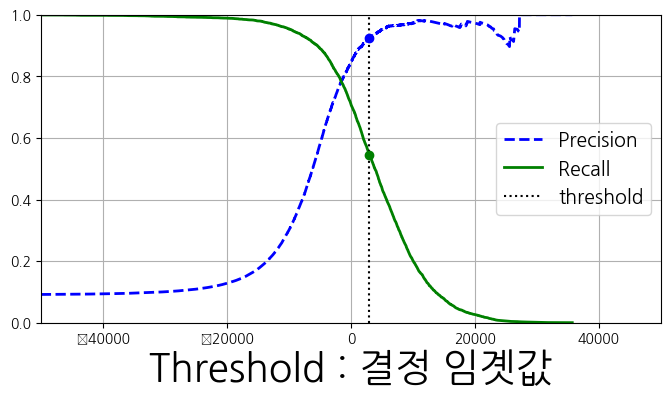

In [38]:
plt.figure(figsize=(8, 4))

# 정밀도 그래프
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)

# 재현율 그래프
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# 결정 임계값이 3000인 경우 확인
threshold = 3000
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 결정 임계값이 3000일 때의 정밀도와 재현율 표시

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")

plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold : 결정 임곗값")
plt.legend(loc="center right")

plt.show()      

- 재현율 대 정밀도 그래프 그리기

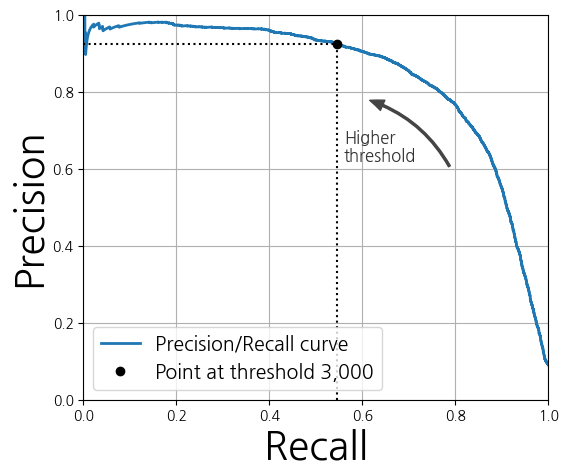

In [39]:
import matplotlib.patches as patches  # 휘어진 화살표 그리기 용도

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# 결정 임계값이 3,000일 때의 정밀도, 재현율율 표시
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")

# 휘어진 화살표
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

# 휘어진 화살표 아내 문구 입력력
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

### 7. 단순 90% 정밀도 분류기 구현하는 것이 좋은 모델인가?

- `SGDClassifier`는 0을 임곗값으로 사용한다. 

- 하지만 90% 정밀도를 지원하는 분류기 모델을 얻고자 한다면 다음과 같이 수동으로 구현할 수 있다.

- 아래 코드를 통해 정밀도 90%가 달성되는 지점의 임곗값을 확인한다.

In [40]:
idx_for_90_precision = (precisions >= 0.90).argmax()

threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

1805.5348693615713

- 실제로 바로 위에서 구해진 임곗값을 사용하면 정밀도가 90%인 모델을 얻게 된다.

In [42]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000270929287456

- 하지만 그렇게 얻어진 모델의 재현율은 48% 정도로 떨어지기에 보편적으로 좋은 모델은 아니다.
    
- 그러나 정밀도가 중요한 상황에서는 유용하므로 사용 목적에 적절한 모델인지 판단해야 한다.

In [43]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

recall_at_90_precision

0.6128020660394761

### 8. ROC 곡선의 AUC

- roc_curve() 함수는 임곗값의 변화에 따른 TPR, FPR 을 계산한다. 

  - TPR : 실제 양성을 얼마나 정확히 분류 했는가 = Recall
  
  - FPR : 실제 음성 중 잘못 분류한 비율 = Fallout

- 아래는 SGDClassifier 모델의 결정 함수가 생성한 값을 계속해서 사용한다.

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

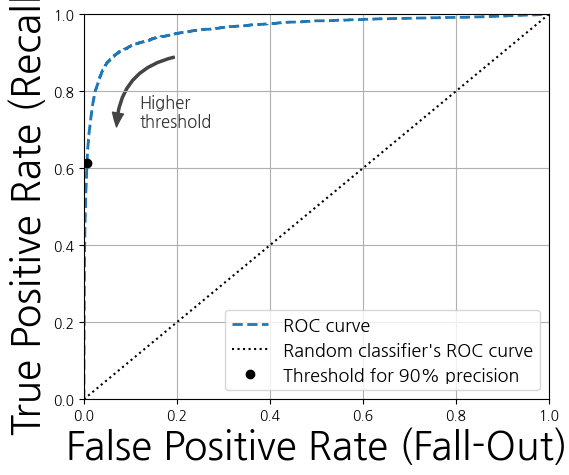

In [45]:
plt.figure(figsize=(6, 5))

# ROC 커브 그리기
plt.plot(fpr, tpr, '--', linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

# 정밀도 90%의 위치 표시
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 기타 요소 표시
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

- ROC 커브의 아래 면적 AUC는 다음과 같이 0.9622 이다.

In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9622621628373703

### 9. SGD와 RandomForest 모델 성능 비교

#### 9.1 RandomForest



- 랜덤 포레스트 분류기는 `predict_proba()` 메서드를 결정함수로 사용한다. 

- `predict_proba()` 메서드는 입력 샘플에 대해 각 클래스에 속할 확률을 계산한다. 

- 여기서는 숫자 5가 아닌 경우(음성)와 숫자 5인 경우(양성)에 대한 확률값을 담은 길이가 2인 튜플을 계산한다. 

- 양성으로 판정하는 기준값, 즉 결정 임계값은 0.5을 사용한다. 즉 계산된 양성일 확률이 0.5보다 같거나 큰 경우 양성으로 판정한다.

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=2024)

In [48]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- y_probas_forest는 각 샘플에 대해 숫자 5를 가리킬 확률을 결정 함숫값으로 계산한다.

In [49]:
y_probas_forest

array([[0.17, 0.83],
       [0.98, 0.02],
       [0.98, 0.02],
       ...,
       [0.04, 0.96],
       [0.95, 0.05],
       [0.92, 0.08]])

- 숫자 5 여부에 대해 양성인 확률에 대한 예측값을 이용하여 정밀도-재현율 곡선(PR 곡선)을 그린다.

In [50]:
y_scores_forest = y_probas_forest[:, 1]  # 양성일 확률 / 임계값에 따른 정밀도, 재현율 계산

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

- 아래 SGCClassifier와 RandomForestClassifier 두 모델의 ROC 커브를 확인하면 RandomForestClassifier 분류기의 성능이 보다 좋다.

In [51]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

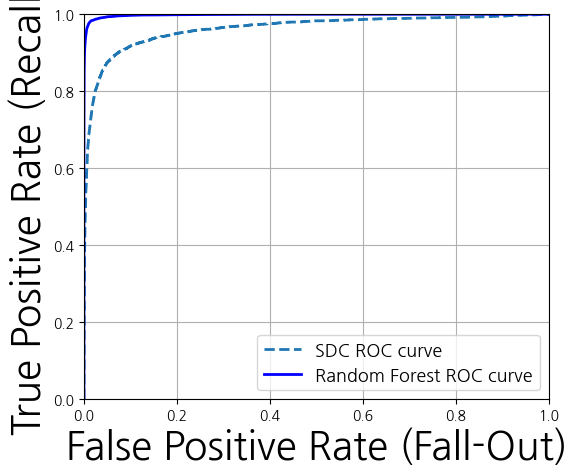

In [52]:
plt.figure(figsize=(6, 5))

# ROC 커브 그리기

plt.plot(fpr, tpr, '--', linewidth=2, label="SDC ROC curve")
plt.plot(fpr_forest, tpr_forest, 'b-', linewidth=2, label="Random Forest ROC curve")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

- PR(정밀도 대 재현율) 그래프로 비교해 보더라도 RandomForestClassifier 가 훨씬 좋은 성능을 보임을 확인할 수 있다.

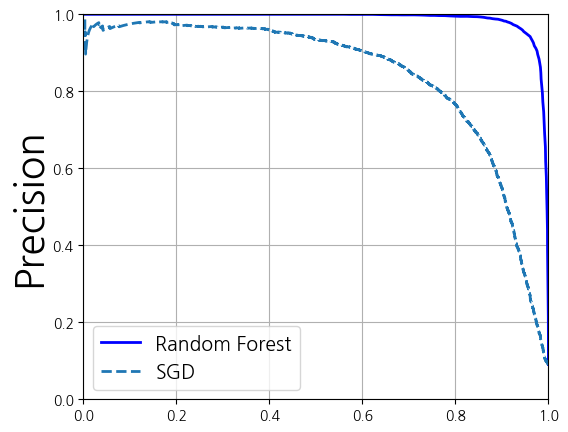

In [53]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

**[랜덤 포레스트 모델 성능 요약]**

- 0.5를 결정 임곗값으로 사용할 경우 F1 점수, AUC, 정밀도, 재현율은 아래과 같이 매우 우수한 성능을 보인다.

In [56]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률이 0.5 이상인 경우

print(f"F1_Score 점수 : {f1_score(y_train_5, y_train_pred_forest)}")

print(f"ROC_AUC_Score 점수 : {roc_auc_score(y_train_5, y_scores_forest)}")

print(f"Precision_Score 점수 : {precision_score(y_train_5, y_train_pred_forest)}")

print(f"Recall_Score 점수 : {recall_score(y_train_5, y_train_pred_forest)}")

F1_Score 점수 : 0.9284874608150471
ROC_AUC_Score 점수 : 0.9982979423259443
Precision_Score 점수 : 0.9899728431167746
Recall_Score 점수 : 0.874192953329644


#### 9.2 SVC

- 서포트 벡터 머신(SVM) 모델은 큰 데이터셋을 이용한 훈련이 매우 오래걸려 `SVC` 모델은 기본적으로 일대일(OvO) 방식을 사용한다.

In [57]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=2024)
svm_clf.fit(X_train[:60000], y_train[:60000])

SVC(random_state=2024)

- 숫자 5를 가리키는 some_digit 손글씨 숫자를 5라고 정확히 예측한다.

In [58]:
svm_clf.predict([X[0]])

array(['5'], dtype=object)

- 일대일 결투 결과를 실제로 확인하면 5번 범주가 가리키는 숫자 대 다른 숫자와의 대결이 가장 높은 승률을 보였음을 아래 코드가 확인해준다.

- 10개의 값은 각 범주가 10번의 대결에서 이긴 경우의 수를 가리킨다. 단, 무승부를 방지하기 위해 최대 0.33을 더하거나 뺐다.

- 가장 많은 일대일 승부를 이긴 범주는 5번이다.

In [60]:
some_digit_scores = svm_clf.decision_function([X[0]])

some_digit_scores.round(2)

array([[ 1.73,  2.73,  7.25,  8.31, -0.31,  9.31,  1.71,  2.77,  6.23,
         4.85]])

### 10. 일대일 또는 일대다 전략 선택

이진 분류기를 일대일 전략 또는 일대다 전략으로 지정해서 학습하도록 만들 수 있다.

- `OneVsOneClassifier` 클래스: 일대일 전략 지원

- `OneVsRestClassifier` 클래스: 일대다 전략 지원

In [61]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=2024))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=2024))

In [62]:
ovr_clf.predict([X[0]])

array(['5'], dtype='<U1')

In [63]:
len(ovr_clf.estimators_)

10

**[다중 클래스 분류 모델 교차 검증]**

- MNIST의 경우 0부터 9까지 숫자가 균형 있게 분포되어 있어서 정확도를 기준으로 교차 검증을 진행할 수 있다.

- 예를 들어, `SGDClassifier` 모델은 기본적으로 OvR(일대다) 방식을 사용하여 다중 클래스 분류를 진행한다. 

- 그런데 MNIST에 대해 성능이 별로 높지 않다. 심지어 첫째 샘플에 대한 예측도 실패한 것을 확인할 수 있다.

In [65]:
sgd_clf = SGDClassifier(random_state=2024)

sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=2024)

In [68]:
sgd_clf.predict([X[0]])

array(['3'], dtype='<U1')

- 또한 결정 함수의 점수도 매우 낮다.

In [69]:
sgd_clf.decision_function([X[0]]).round()

array([[-10622., -33499.,  -8858.,   2313., -23172.,  -2915., -25045.,
        -14687.,  -9319., -16449.]])

- 정확도를 활용한 교차 검증 점수가 87% 정도로 그렇게 훌륭하지 않다.

In [70]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86975, 0.89225, 0.8589 ])

- 하지만 표준화 스케일링만 해도 성능이 좀 더 향상된다.

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

c:\Users\gmlck\.conda\envs\yolov8\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.8999 , 0.8975 , 0.90335])

### 11. Error 분석 : 오차행렬 시각화

- 아래 두 이미지는 위 예측값을 이용하여 다중 클래스 분류기의 오차행렬을 그린다.

    - 왼쪽 이미지: 다중 클래스 분류 모델의 오차 행렬을 색상과 함께 표현한다.

    - 오른쪽 이미지: 행별 퍼센티지의 합이 100 이 되도록 정규화한다.

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

c:\Users\gmlck\.conda\envs\yolov8\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


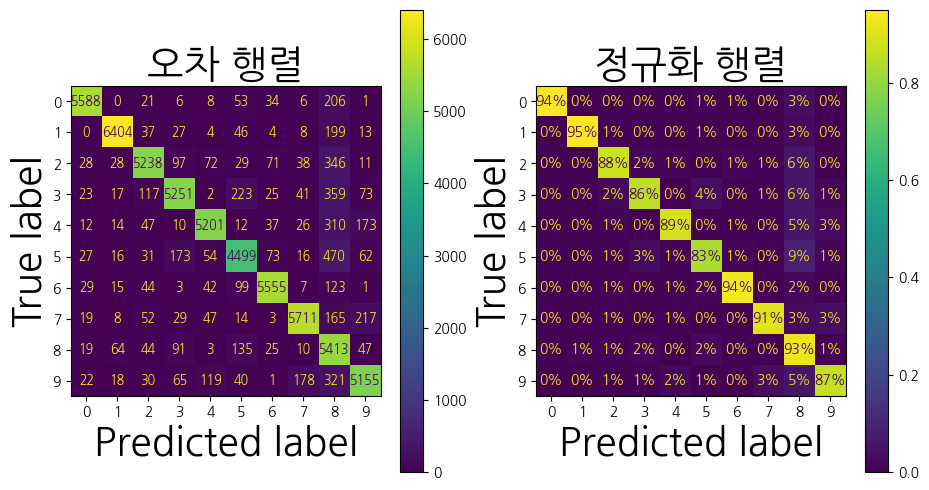

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
plt.rc('font', size=9)

# 왼쪽 이미지
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("오차 행렬", )

# 오른쪽 이미지: 왼쪽 이미지 정규화
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("정규화 행렬")
plt.show()

**[오차율 활용]**

- 왼쪽 이미지: 올바르게 예측된 샘플을 제외한 후에 행별로 오인된 숫자의 비율을 확인하면 다음과 같다

    - `sample_weight` 키워드 인자 활용
    
    - 많은 숫자가 8로 잘못 예측됨

- 오른쪽 이미지: 칸별 정규화 진행 결과를 보여준다.

    - 7로 오인된 숫자중에 9가 56% 차지

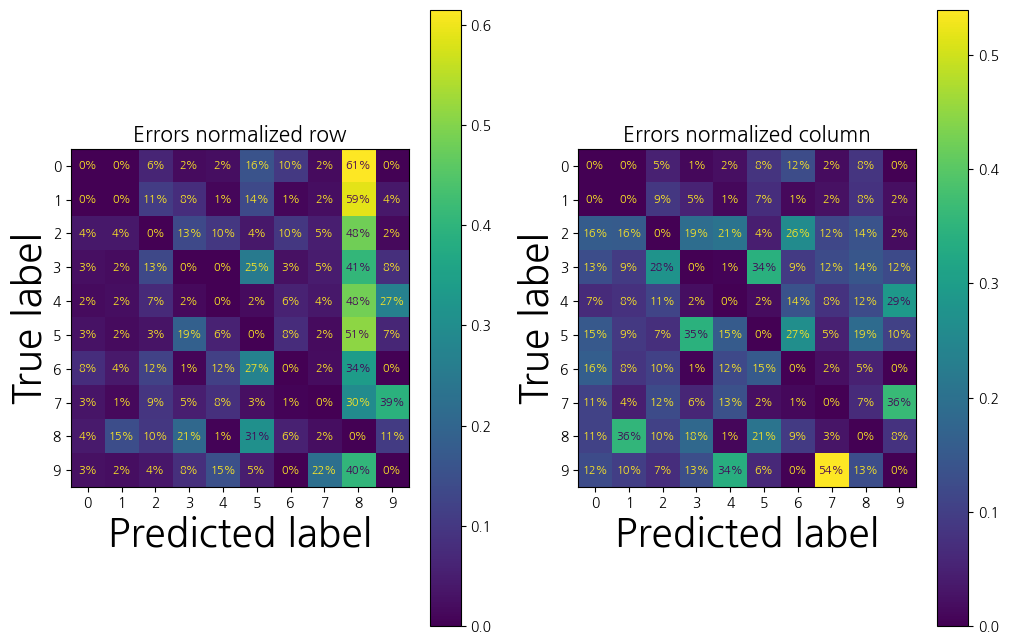

In [99]:
sample_weight = (y_train_pred != y_train) # 가중치: 정확한 예측은 1, 아니면 0

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

plt.rc('font', size=8)

# 왼쪽 이미지
left_plt = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                                   sample_weight=sample_weight,
                                                   normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized row", fontsize=15)

# 오른쪽 이미지지
right_plt = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                                    sample_weight=sample_weight,
                                                    normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized column", fontsize=15)

plt.show()

**[개별 오류 확인]**

- 위 오른쪽 이미지에 의하면 5로 오인된 이미지 중에서 숫자 3 이미지의 비율이 38%로 가장 높다. 

- 실제로 오차 행렬과 유사한 행렬을 3과 5에 대해 나타내면 다음과 같다.

    - 음성 : 3으로 판정
    - 양성 : 5로 판정

In [75]:
cl_a, cl_b = '3', '5'

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

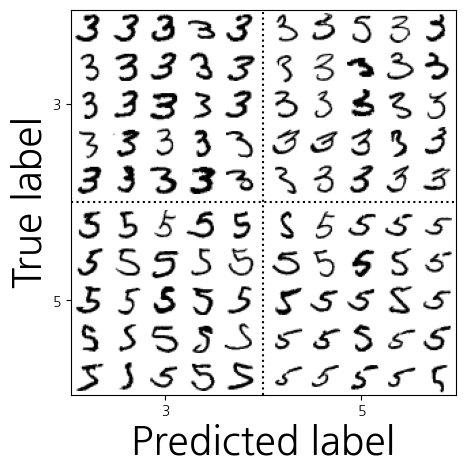

In [100]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2

plt.figure(figsize=(size, size))

for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
        
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])

plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")

plt.axis([0, 2 * size + pad, 0, 2 * size + pad])

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

### 12. 다중 클래스 분류 일반화

#### 12.1. 다중 레이블 분류

- 아래 코드는 각 숫자 이미지에 대해 7이상인지 여부와 홀수인지 여부를 동시에 판단하는 분류 모델을 구현한다.

In [89]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [90]:
knn_clf.predict([X[0]])

array([[False,  True]])

- 다중 레이블 분류 모델을 평가한다.

In [91]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [92]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [93]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [94]:
chain_clf.predict([X[0]])

array([[0., 1.]])

#### 12.2 다중 출력 분류

- 노이즈가 포함된 사진에서 원본 사진을 예측하는 분류 모델을 구현한다.

In [95]:
np.random.seed(2024)

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

- 훈련 이미지 샘플 하나와 타깃 이미지 샘플 하나는 다음과 같다.

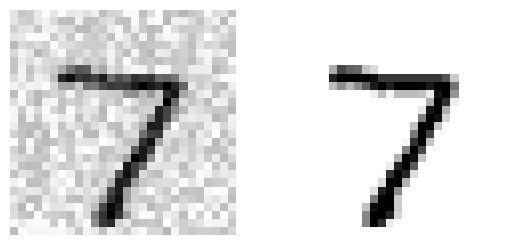

In [96]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

- 예측값을 활용한 이미지는 거의 7에 가깝다.

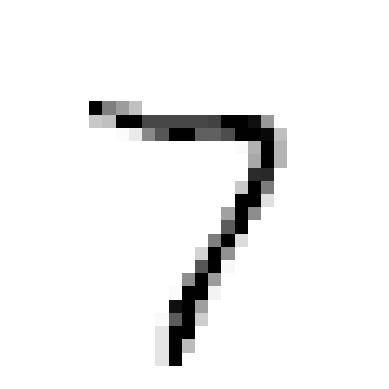

In [97]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

plot_digit(clean_digit)
plt.show()